In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import warnings
from itertools import groupby
warnings.filterwarnings('ignore')


In [82]:
data_workshop=pd.read_csv('Workshop_PUSO.csv',sep=';')

In [84]:
data_workshop.query('is_puso==1').groupby(['tahun','bulan'])['idsegmen'].agg('count')

tahun  bulan
22     1         47
       2         32
       3         13
       4         21
       5         14
       6         27
       7         13
       8         25
       9         19
       10         3
       11         5
       12        12
23     1          6
       2          6
       3          8
       4          3
       5         14
       6         16
       7         68
       8         85
       9         82
       10       109
       11        43
       12        13
Name: idsegmen, dtype: int64

In [2]:
data_workshop=pd.read_csv('Workshop_PUSO.csv',sep=';')

In [3]:
def extract_precipitation_indices(lat, lon,dstp):
    # Extract the precipitation values for all times at the nearest lat/lon point
    precipitation_values = dstp['tp'].sel(latitude=lat, longitude=lon, method='nearest').values*1000
    # get the minimum prepc
    min_precop=np.min(precipitation_values)
    # get the max prepc
    max_precop=np.max(precipitation_values)
    # get the mean prepc
    mean_precop=np.mean(precipitation_values)
    # get the max prepc
    std_precop=np.std(precipitation_values)
    # get the dry days in mont
    drydays_month=(precipitation_values<1).sum()
    # Count the longest streak of consecutive dry days
    is_dry = precipitation_values < 1
    # Find streaks of consecutive dry days
    longest_dry_streak = max((len(list(g)) for k, g in groupby(is_dry) if k), default=0)
    # Heavy Percipitation Days
    heavy_prec_days=(precipitation_values > 10).sum()
    return min_precop,max_precop,mean_precop,std_precop,drydays_month,longest_dry_streak,heavy_prec_days

In [4]:
def extract_temperature_indices(lat, lon,dst2m ,dst2max,dst2min):
    # Extract the precipitation values for all times at the nearest lat/lon point
    temperature_values = dst2m['t2m'].sel(latitude=lat, longitude=lon, method='nearest').values-273.15
    # get the minimum prepc
    min_temper=np.min(temperature_values)
    # get the max prepc
    max_temper=np.max(temperature_values)
    # get the mean prepc
    mean_temper=np.mean(temperature_values)
    # get the max prepc
    std_temper=np.std(temperature_values)
    
    # Calculate Growing Degree Day with 10 degree C as Tbase ==> harusnya dihitung dari tahap 0 persiapan lahan
    temp_max_values = dst2max['t2m'].sel(latitude=lat, longitude=lon, method='nearest').values-273.15
    temp_min_values = dst2min['t2m'].sel(latitude=lat, longitude=lon, method='nearest').values-273.15
    gdd=((temp_max_values-temp_min_values)/2)-10
    gdd_min=np.min(gdd)
    gdd_max=np.max(gdd)
    gdd_mean=np.mean(gdd)
    gdd_daily = np.where(gdd > 0,gdd, 0)  # Set GDD to 0 if it's negative
    # Accumulate GDD over the growing season
    gdd_cumulative = np.cumsum(gdd_daily)
    gdd_accumulated_months=gdd_cumulative[-1]

    # Heat Stress Days
    t_excess=temp_max_values>35.4
    heat_stress_days=t_excess.sum()
    
    return min_temper,max_temper,mean_temper,std_temper,gdd_min,gdd_max,gdd_mean,gdd_accumulated_months,heat_stress_days

In [5]:
def extract_humidity_indices(lat, lon,dst2m ,dsdew):
    # calcluate VPD Formula
    temperature_values = dst2m['t2m'].sel(latitude=lat, longitude=lon, method='nearest').values-273.15
    dew_values=dsdew['d2m'].sel(latitude=lat, longitude=lon, method='nearest').values-273.15
    # saturation vapor pressure 
    es_value=(610.94*(np.exp((17.625 * temperature_values) / (temperature_values + 243.04))))
    # actual vapor preasure
    ac_value=(610.94*(np.exp((17.625 * dew_values) / (dew_values + 243.04))))
    vpd_value=es_value-ac_value
    vpd_min=np.min(vpd_value)
    vpd_max=np.max(vpd_value)
    vpd_mean=np.mean(vpd_value)
    # high VPD days
    high_vpd_day=(vpd_value>2).sum()
    # low VPD days
    low_vpd_day=(vpd_value<0.5).sum()
    # Relative Humidity
    rh_value=ac_value/es_value*100
    rh_min=np.min(rh_value)
    rh_max=np.max(rh_value)
    rh_mean=np.mean(rh_value)
    # high RH day
    high_rh_day=(rh_value>80).sum()
    # low RH day
    low_rh_day=(rh_value<40).sum()
    return vpd_min,vpd_max,vpd_mean,high_vpd_day,low_vpd_day,rh_min,rh_max,rh_mean,high_rh_day,low_rh_day

In [6]:
def extract_crr_indices(lat, lon,dscrr):
    crr = dscrr['crr'].sel(latitude=lat, longitude=lon, method='nearest').values
    heavy_rain_days=(crr>0.0021).sum()
    heavy_storm_days=(crr>0.0139).sum()
    return heavy_rain_days, heavy_storm_days


In [36]:
def extract_evapo_indices(lat, lon,dspe,dsev,dstp):
    pe=dspe['pev'].sel(latitude=lat, longitude=lon, method='nearest').values
    ev=dsev['e'].sel(latitude=lat, longitude=lon, method='nearest').values
    tp=dstp['tp'].sel(latitude=lat, longitude=lon, method='nearest').values
    # saturation vapor pressure 
    pe_min=np.min(pe)
    pe_max=np.max(pe)
    pe_mean=np.mean(pe)

    ev_min=np.min(ev)
    ev_max=np.max(ev)
    ev_mean=np.mean(ev)

    et_ratio=np.divide(ev, pe, out=np.zeros_like(ev, dtype=float), where=pe != 0)
    et_min=np.min(et_ratio)
    et_max=np.max(et_ratio)
    et_mean=np.mean(et_ratio)

    ep_ratio=np.divide(ev, tp, out=np.zeros_like(ev, dtype=float), where=tp != 0)
    ep_min=np.min(ep_ratio)
    ep_max=np.max(ep_ratio)
    ep_mean=np.mean(ep_ratio)

    wdi=pe-ev
    wdi_min=np.min(wdi)
    wdi_max=np.max(wdi)
    wdi_mean=np.mean(wdi)
   
    return pe_min, pe_max,pe_mean,ev_min, ev_max,ev_mean,et_min, et_max,et_mean,ep_min, ep_max,ep_mean,wdi_min,wdi_max,wdi_mean

In [8]:
def extract_soil_indices(lat, lon,dsst,dsswl):
    stl=dsst['stl1'].sel(latitude=lat, longitude=lon, method='nearest').values-273.15
    stl_min=np.min(stl)
    stl_max=np.max(stl)
    stl_mean=np.mean(stl)
    days_stl_stress=(stl>35).sum()
    
    swl=dsswl['swvl1'].sel(latitude=lat, longitude=lon, method='nearest').values
    swl=np.where(swl<0,0,swl)
    swl_min=np.min(swl)
    swl_max=np.max(swl)
    swl_mean=np.mean(swl)
    smsi=(swl-0.15)/0.2
    smsi=np.where(smsi<0,0,smsi)
    smsi=np.where(smsi>1,1,smsi)
    smsi_min=np.min(smsi)
    smsi_max=np.max(smsi)
    smsi_mean=np.mean(smsi)
    return stl_min, stl_max,stl_mean,days_stl_stress, swl_min,swl_max,swl_mean, smsi_min,smsi_max,smsi_mean

In [37]:
data_compile=pd.DataFrame()
print('+++++++++++++++++++++++++++++++++++++')
for i in data_workshop.tahun.unique():
    for j in data_workshop.bulan.unique():
        print(f'Running for Tahun:{i} and Bulan:{j}')
        temp=data_workshop.query('tahun==@i and bulan==@j')
        periode='20'+str(i)+'_'+str(j).zfill(2)
        
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/total_precipitation_0_daily-mean.nc"
        dstp = xr.open_dataset(netcdf_file)
        temp[['precip_min','precip_max','precip_mean','precip_std','drydays_month','drydays_streak','heavy_precdays']] = temp.apply(lambda row: pd.Series(extract_precipitation_indices(row['latitude'], row['longitude'],dstp)), axis=1)
        print('=====Precipitation=====')
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/2m_temperature_0_daily-mean.nc"
        dst2m = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data_max/2m_temperature_0_daily-max.nc"
        dst2max = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data_min/2m_temperature_0_daily-min.nc"
        dst2min = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/2m_dewpoint_temperature_0_daily-mean.nc"
        temp[['min_temper','max_temper','mean_temper','std_temper','gdd_min','gdd_max','gdd_mean','gdd_accumulated_months','heat_stress_days']] = temp.apply(lambda row: pd.Series(extract_temperature_indices(row['latitude'], row['longitude'],dst2m,dst2max,dst2min)), axis=1)
        print('=====Temperature=====')
        dsdew = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/convective_rain_rate_0_daily-mean.nc"
        temp[['vpd_min','vpd_max','vpd_mean','high_vpd_day','low_vpd_day','rh_min','rh_max','rh_mean','high_rh_day','low_rh_day']] = temp.apply(lambda row: pd.Series(extract_humidity_indices(row['latitude'], row['longitude'],dst2m,dsdew)), axis=1)
        print('=====Humidity=====')
        dscrr = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/potential_evaporation_0_daily-mean.nc"
        temp[['heavy_rain_days','heavy_storm_days']] = temp.apply(lambda row: pd.Series(extract_crr_indices(row['latitude'], row['longitude'],dscrr)), axis=1)
        print('=====Rainny=====')
        dspe = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/evaporation_0_daily-mean.nc"
        dsev = xr.open_dataset(netcdf_file)
        temp[['pe_min', 'pe_max','pe_mean','ev_min', 'ev_max','ev_mean','et_min', 'et_max','et_mean','ep_min', 'ep_max','ep_mean','wdi_min','wdi_max','wdi_mean']] = temp.apply(lambda row: pd.Series(extract_evapo_indices(row['latitude'], row['longitude'],dspe,dsev,dstp)), axis=1)
        print('=====Evaporation=====')
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/soil_temperature_level_1_0_daily-mean.nc"
        dsst = xr.open_dataset(netcdf_file)
        netcdf_file = f"/data/ksa/00_Code/12_Workshop_Puso/climate_data/{periode}_data/volumetric_soil_water_layer_1_0_daily-mean.nc"
        dsswl= xr.open_dataset(netcdf_file)
        temp[['stl_min', 'stl_max','stl_mean','days_stl_stress', 'swl_min','swl_max','swl_mean',  'smsi_min','smsi_max','smsi_mean']] = temp.apply(lambda row: pd.Series(extract_soil_indices(row['latitude'], row['longitude'],dsst,dsswl)), axis=1)
        print('=====Soil Moisture=====')

        data_compile=pd.concat([data_compile,temp])

print('+++++++++++++++++++++++++++++++++++++')

+++++++++++++++++++++++++++++++++++++
Running for Tahun:23 and Bulan:9
=====Precipitation=====
=====Temperature=====
=====Humidity=====
=====Rainny=====
=====Evaporation=====
=====Soil Moisture=====
Running for Tahun:23 and Bulan:8
=====Precipitation=====
=====Temperature=====
=====Humidity=====
=====Rainny=====
=====Evaporation=====
=====Soil Moisture=====
Running for Tahun:23 and Bulan:3
=====Precipitation=====
=====Temperature=====
=====Humidity=====
=====Rainny=====
=====Evaporation=====
=====Soil Moisture=====
Running for Tahun:23 and Bulan:1
=====Precipitation=====
=====Temperature=====
=====Humidity=====
=====Rainny=====
=====Evaporation=====
=====Soil Moisture=====
Running for Tahun:23 and Bulan:6
=====Precipitation=====
=====Temperature=====
=====Humidity=====
=====Rainny=====
=====Evaporation=====
=====Soil Moisture=====
Running for Tahun:23 and Bulan:7
=====Precipitation=====
=====Temperature=====
=====Humidity=====
=====Rainny=====
=====Evaporation=====
=====Soil Moisture==

In [38]:
data_compile.to_csv('data_compile_agro_climate.csv',sep=';',index=False)

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

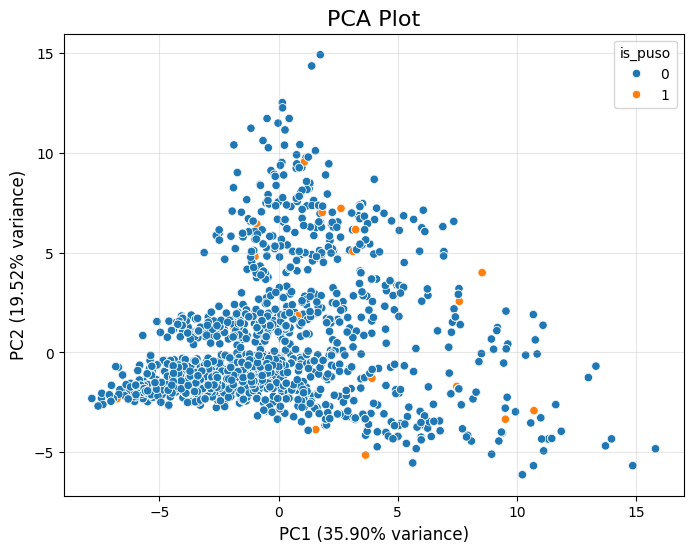

In [59]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_compile[['precip_min', 'precip_max', 'precip_mean', 'precip_std',
       'drydays_month', 'drydays_streak', 'heavy_precdays', 'min_temper',
       'max_temper', 'mean_temper', 'std_temper', 'gdd_min', 'gdd_max',
       'gdd_mean', 'gdd_accumulated_months', 'heat_stress_days', 'vpd_min',
       'vpd_max', 'vpd_mean', 'high_vpd_day', 'low_vpd_day', 'rh_min',
       'rh_max', 'rh_mean', 'high_rh_day', 'low_rh_day', 'heavy_rain_days',
       'heavy_storm_days', 'pe_min', 'pe_max', 'pe_mean', 'ev_min', 'ev_max',
       'ev_mean', 'et_min', 'et_max', 'et_mean', 'ep_min', 'ep_max', 'ep_mean',
       'wdi_min', 'wdi_max', 'wdi_mean', 'stl_min', 'stl_max', 'stl_mean',
       'days_stl_stress', 'swl_min', 'swl_max', 'swl_mean', 'smsi_min',
       'smsi_max', 'smsi_mean']])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
data_compile[['PC1','PC2']]=pca_result
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Step 5: Create the PCA scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_compile, x='PC1', y='PC2', hue='is_puso')
plt.title('PCA Plot', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

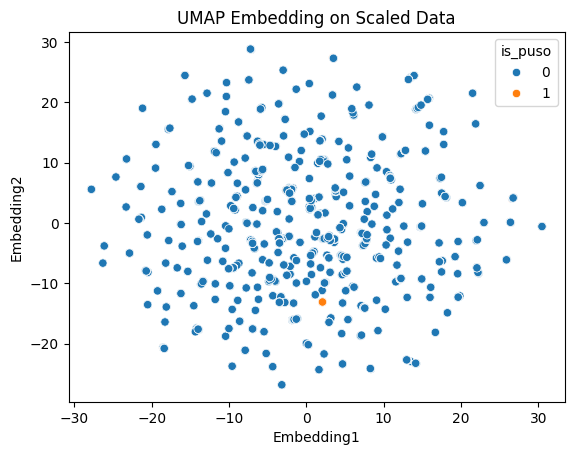

In [74]:
import umap.umap_ as umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data_scaled)
data_compile[['Embedding1','Embedding2']]=embedding
# Plot as before
sns.scatterplot(data=data_compile, x='Embedding1', y='Embedding2', hue='is_puso')
plt.title("UMAP Embedding on Scaled Data")
plt.show()

In [77]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
X=data_compile[['precip_min', 'precip_max', 'precip_mean', 'precip_std',
       'drydays_month', 'drydays_streak', 'heavy_precdays', 'min_temper',
       'max_temper', 'mean_temper', 'std_temper', 'gdd_min', 'gdd_max',
       'gdd_mean', 'gdd_accumulated_months', 'heat_stress_days', 'vpd_min',
       'vpd_max', 'vpd_mean', 'high_vpd_day', 'low_vpd_day', 'rh_min',
       'rh_max', 'rh_mean', 'high_rh_day', 'low_rh_day', 'heavy_rain_days',
       'heavy_storm_days', 'pe_min', 'pe_max', 'pe_mean', 'ev_min', 'ev_max',
       'ev_mean', 'et_min', 'et_max', 'et_mean', 'ep_min', 'ep_max', 'ep_mean',
       'wdi_min', 'wdi_max', 'wdi_mean', 'stl_min', 'stl_max', 'stl_mean',
       'days_stl_stress', 'swl_min', 'swl_max', 'swl_mean', 'smsi_min',
       'smsi_max', 'smsi_mean']]
y=data_compile['is_puso']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

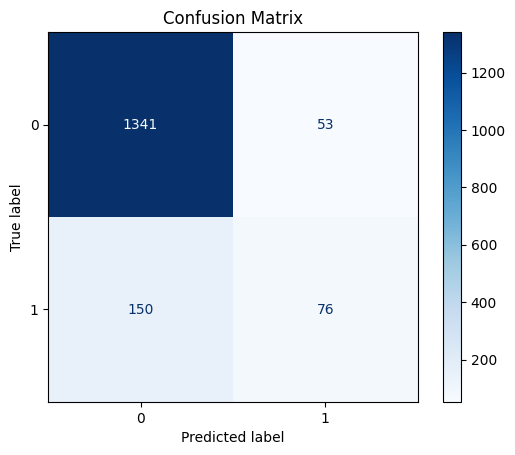

Accuracy: 0.8746913580246913
ROC AUC: 0.7875249171544292

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1394
           1       0.59      0.34      0.43       226

    accuracy                           0.87      1620
   macro avg       0.74      0.65      0.68      1620
weighted avg       0.86      0.87      0.86      1620



In [79]:
model = XGBClassifier(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=5,           # Max depth of trees
    random_state=42,       # Reproducibility
    use_label_encoder=False  # For compatibility with sklearn
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', colorbar=True)

# Show the plot
plt.title("Confusion Matrix")
plt.show()
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

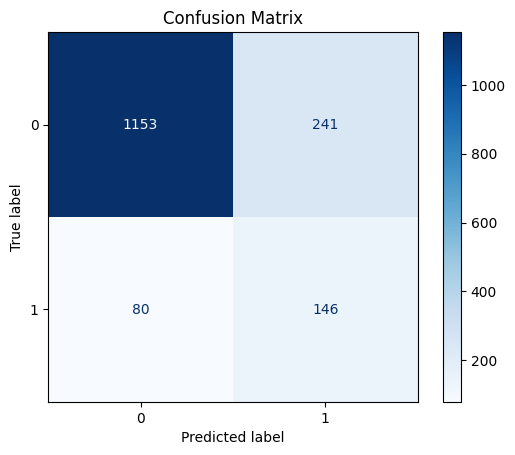

Accuracy: 0.8018518518518518
ROC AUC: 0.7871821078960399

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1394
           1       0.38      0.65      0.48       226

    accuracy                           0.80      1620
   macro avg       0.66      0.74      0.68      1620
weighted avg       0.86      0.80      0.82      1620



In [81]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
model = XGBClassifier(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=5,           # Max depth of trees
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,       # Reproducibility
    use_label_encoder=False  # For compatibility with sklearn
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', colorbar=True)

# Show the plot
plt.title("Confusion Matrix")
plt.show()
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))